# Assignment 1 - Travelling Salesman Problem with Genetic Algorithms
Notes while learning

- Travelling Salesman Problem: given a set of cities, find the shortest path to visit each city exactly once
    and return to the starting city. (fully connected graph)

- Genetic Algorithms are heuristic search algorithms that are built on the concepts of the evolution of life,
    replicating the process of natural selection.Travelling Salesman Problem: given a set of cities, find the shortest path to visit each city exactly once
    and return to the starting city.

- Genetic Algorithms are heuristic search algorithms that are built on the concepts of the evolution of life,
    replicating the process of natural selection.
    - NP-Hard -> cant be solved in polynomial time
        - We use heuristics
    
- Factorial using brute force 30! 2.65 x 10^32 -> can check all  o(n!)
- Nearest neighbour o(n^2) -> checks all neighbours and goes to nearest

Tour length: lower equals better fitness
- statistically favouring more fit
- elitism
- more fit higher probability
- k-way tournament selection / /roulette

Genome represents a potential solution to the problem, typically encoded structure
- sequence (permutation) of cities representing a potential route
- each gene in the genome corresponds to a city in the tour
- each genome is an ordered list of cities [a, c, d, b]
- genome length is the number of cities
- mutation and crossover operators modify genomes to improve solutions

Crossover
edge recombination crossover: selects edges from one or both parents and combines them into a new solution

Mutation
- how often to mutate
- Displacement mutation: randomly selects a sub tour in given tour and shift to randomly selected within the tour

Repeat steps until we have generated enough offspring to comprise a new population -> fitness plateo ( the best fitness doesn't improve for 2 consecutive generations)

# Keyword Translation
- Genome (Chromosome)	A full tour (sequence of cities)
- Gene	A single city in the tour
- Population	A set of different routes
- Fitness Function	Total tour distance (lower is better)
- Selection	Choose the best tours (parents)
- Crossover	Combine two routes to create a new one
- Mutation	Swap or modify parts of a tour
- Termination	Stop after many generations or no improvement

### Imports

In [94]:
import matplotlib.pyplot as plt
import random
import time
import numpy as np

### Load the Data Sets TSP.txt and get return nodes and distance matrix

In [95]:
# Load TSP Data
def read_tsp_file(filename):
    """
    Reads a TSP file and extracts city coordinates.

    Parameters:
    filename (str): Path to the TSP file.

    Returns:
    dict: A dictionary where keys are city IDs and values are (x, y) coordinates.
    """
    cities = {}
    with open(filename, 'r') as file:
        node_section = False
        for line in file:
            line = line.strip()
            if line.startswith("NODE_COORD_SECTION"):
                node_section = True
                continue
            if line == "EOF":
                break
            if node_section:
                parts = line.split()
                if len(parts) == 3:
                    try:
                        city_id = int(parts[0])
                        x, y = map(float, parts[1:])
                        cities[city_id] = (x, y)
                    except ValueError:
                        print(f"Skipping invalid line: {line}")
    return cities

In [96]:
def calculate_distance_matrix(cities):
    """
    Computes the distance matrix for a given set of cities.

    Parameters:
    cities (dict): A dictionary where keys are city IDs and values are (x, y) coordinates.

    Returns:
    np.ndarray: A 2D array representing distances between each pair of cities.
    """
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    city_ids = list(cities.keys())  # List of city IDs for indexing
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:  # No need to compute distance from a city to itself
                x1, y1 = cities[city_ids[i]]
                x2, y2 = cities[city_ids[j]]
                distance_matrix[i, j] = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)  # Euclidean distance
    return distance_matrix

## 1. Initialize the population

In [97]:
def random_genome(length):
    """
    Creates a random genome of city indices from 0 to length-1 (inclusive),
    where each number represents a city index.
    """
    # Create a list of city indices (from 0 to length-1)
    numbers = list(range(length))  # City indices should be from 0 to length-1
    random.shuffle(numbers)  # Shuffle to generate a random route
    return numbers

In [98]:
def init_population(population_size, genome_length):
    """
    Creates a population of random genomes (routes) for the TSP problem.

    Parameters:
    population_size (int): The number of individuals (routes) in the population.
    genome_length (int): The number of cities (length of each route).

    Returns:
    list: A population where each individual is a list of city indices.
    """
    return [random_genome(genome_length) for _ in range(population_size)]


## 2. Calculate Fitness of Individuals (Evaluation)

In [99]:
def fitness(individual, distance_matrix):
    """
    Calculates the fitness of a given individual (route) based on the total distance traveled.
    The shorter the distance, the higher the fitness.

    Parameters:
    individual (list): A list of city indices representing the route.
    distance_matrix (np.ndarray): A 2D array representing the distances between cities.

    Returns:
    float: The fitness value of the individual (shorter distance = higher fitness).
    """
    total_distance = 0
    # Calculate the total distance for the route
    for i in range(len(individual) - 1):
        city1 = individual[i]
        city2 = individual[i + 1]
        total_distance += distance_matrix[city1, city2]

    # Add distance from the last city back to the first one to make it a closed loop
    total_distance += distance_matrix[individual[-1], individual[0]]

    return total_distance  # Return the total distance itself

In [100]:
def fitness_population(population, distance_matrix):
    """
    Calculates the fitness for the entire population of individuals (routes).

    Parameters:
    population (list): A list of individuals (routes) represented by city indices.
    distance_matrix (np.ndarray): A 2D array representing the distances between cities.

    Returns:
    list: A list of fitness values corresponding to each individual in the population.
    """
    return [fitness(individual, distance_matrix) for individual in population]

## 3. Selection

In [101]:
"""
Selection: initializing a process that enables the tours with better fitness to have a higher probabilistic chance of being chosen for reproduction
- Selection Mechanisms
    - Roulette Wheel Selection: enables the individuals with higher fitness scores to have a higher probabilistic chance of being selected
    - Tournament Selection: chooses a random subset of the data and chooses the individual with the best fitness score
    
Tournament Selection
- select k-individuals and run a tournament
- only fittest are selected and can pass onto next generation
- selection pressure (tournament size): determines how strongly the best individuals are favored
    - Larger tour size: weak candidates have a smaller chance of getting selected as it has to compete with stronger ones
    determines rate of convergence of the GA
    -  higher tournament sizes increase exploitation, while lower tournament sizes encourage exploration.
    n = number of individuals to be selected
    complexity = O(n * k)
"""
def tournament_selection(population, fitness_values):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(enumerate(fitness_values)), tournament_size)
        winner = min(tournament, key=lambda x: x[1])[0]  # Select best
        selected.append(population[winner])
    return selected

## 4. Crossover (at least two operators)

In [102]:
"""
Crossover: creating new individuals by combining genetic information from two or more parent individuals
(emulates genetic recombination) -> output == offspring

Two Operators
    - Order Crossover (OX1): preserves order and avoids duplication
    - Partially Mapped Crossover (PMX): ensures valid offspring by mapping parent genes correctly
"""

# 1. OX1
def order_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [-1] * size
    child[start:end] = parent1[start:end]
    remaining = [city for city in parent2 if city not in child]

    index = 0
    for i in range(size):
        if child[i] == -1:
            child[i] = remaining[index]
            index += 1
    return child


# 2. PMX
def partially_mapped_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))

    child = [-1] * size
    child[start:end] = parent1[start:end]
    mapping = {parent1[i]: parent2[i] for i in range(start, end)}
    for i in range(size):
        if child[i] == -1:
            city = parent2[i]
            # Resolve conflicts using mapping
            while city in mapping:
                city = mapping[city]

            child[i] = city
    return child   

## 5. Mutation (at least two operators)

In [103]:
"""
Mutation: random change to a solution in a population of solutions, used in the hope to generate better solutions

Two Operators:
- Swap Mutation: we select two genes from our chromosome and interchange their values
    Randomly select two cities and swap their positions
    Keeps the tour length the same
    Low disruption but still allows exploration
    
- Inversion Mutation (reverse sequence mutation): select subset of our genes and reverse their order -> the genes have to be contiguous
    Select two random points and reverse the sublist between them.
    Preserves adjacency information.
    Helps maintain locality while introducing diversity.
"""
# Swap Mutation
def swap_mutation(individual):
    i, j = random.sample(range(len(individual)), 2)
    individual[i], individual[j] = individual[j], individual[i]
    return individual


# Inversion
def inversion_mutation(individual):
    i, j = sorted(random.sample(range(len(individual)), 2))
    individual[i:j + 1] = reversed(individual[i:j + 1])
    return individual

In [104]:
def stop_function(no_improvement, gens):
    """
    Handing the stop criteria, stop generations if there's no improvement in a set number of consecutive generations
    """
    return no_improvement >= gens

# Call Genetic Algorithm

In [162]:
def genetic_algorithm(filepath, generations, population_size, crossover_rate, mutation_rate,tournament_size):
    start_time = time.time()
    cities = read_tsp_file(filepath)
    distance_matrix = calculate_distance_matrix(cities)
    population = init_population(population_size, len(cities))

    best_solution = None
    best_fitness = float('inf')
    fitness_history = []

    # fitness plateau
    gens = 200
    no_improvement = 0

    for generation in range(generations):
        fitness_values = fitness_population(population, distance_matrix)

        # Update best solution
        min_fitness = min(fitness_values)
        fitness_history.append(min_fitness)

        if min_fitness < best_fitness:
            best_fitness = min_fitness
            best_solution = population[fitness_values.index(min_fitness)]
            no_improvement = 0  # reset counter
        else:
            no_improvement += 1  # increase counter

        # Print the best fitness for the current generation
        print(f"Generation {generation}: Best Fitness = {best_fitness:.2f}")

        if stop_function(no_improvement, gens):
            print("Stopping criteria reached, no improvement for 200 consecutive generations")
            break

        # Selection
        selected_population = tournament_selection(population, fitness_values)
        # Crossover
        offspring = []
        for i in range(0, len(selected_population) - 1, 2):  # Ensure valid pairs
            parent1, parent2 = selected_population[i], selected_population[i + 1]
            if random.random() < crossover_rate:
                child1 = partially_mapped_crossover(parent1, parent2)
                child2 = partially_mapped_crossover(parent2, parent1)
            else:
                child1, child2 = parent1[:], parent2[:]  # Copy parents if no crossover
            offspring.extend([child1, child2])

        # Mutation
        for i in range(len(offspring)):
            if random.random() < mutation_rate:
                offspring[i] = inversion_mutation(offspring[i])

        population = offspring

    # Final results
    elapsed_time = time.time() - start_time
    average_fitness = np.mean(fitness_history)

    print("\nFinal Best Path:", best_solution)
    print(f"Final Best Distance (Fitness): {best_fitness:.2f}")
    print(f"Average Fitness: {average_fitness:.2f}")
    print(f"Computational Time: {elapsed_time:.2f} seconds")

    return best_solution, best_fitness, fitness_history, elapsed_time

## Plotting 

In [163]:
def plot_results(parameter_sets, filepath, generations, tournament_size):
    for i, (population_size, crossover_rate, mutation_rate) in enumerate(parameter_sets):
        best_solution, best_fitness, fitness_history, elapsed_time = genetic_algorithm(
            filepath, generations, population_size, crossover_rate, mutation_rate, tournament_size
        )

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(fitness_history)), fitness_history, label="Best Fitness", color='blue')
        plt.ylabel("Fitness (Tour length)")
        plt.xlabel("Generations")
        plt.title(
            f"Genetic Algorithm Convergence\nPopulation: {population_size},Crossover Rate: {crossover_rate}, Mutation Rate: {mutation_rate}\n, \nComputational Time: {elapsed_time:.2f} seconds")
        plt.legend()
        plt.grid(True)
        plt.show()

## Testing operators

# Berlin

Generation 0: Best Fitness = 25144.90
Generation 1: Best Fitness = 23557.50
Generation 2: Best Fitness = 23522.27
Generation 3: Best Fitness = 23419.61
Generation 4: Best Fitness = 22916.24
Generation 5: Best Fitness = 22247.41
Generation 6: Best Fitness = 21797.14
Generation 7: Best Fitness = 21031.49
Generation 8: Best Fitness = 20910.28
Generation 9: Best Fitness = 20514.47
Generation 10: Best Fitness = 20101.07
Generation 11: Best Fitness = 20005.84
Generation 12: Best Fitness = 19410.22
Generation 13: Best Fitness = 19292.70
Generation 14: Best Fitness = 18941.37
Generation 15: Best Fitness = 18714.97
Generation 16: Best Fitness = 18125.02
Generation 17: Best Fitness = 18125.02
Generation 18: Best Fitness = 17753.50
Generation 19: Best Fitness = 17341.20
Generation 20: Best Fitness = 17221.36
Generation 21: Best Fitness = 16890.38
Generation 22: Best Fitness = 16743.09
Generation 23: Best Fitness = 16743.09
Generation 24: Best Fitness = 16089.56
Generation 25: Best Fitness = 16022

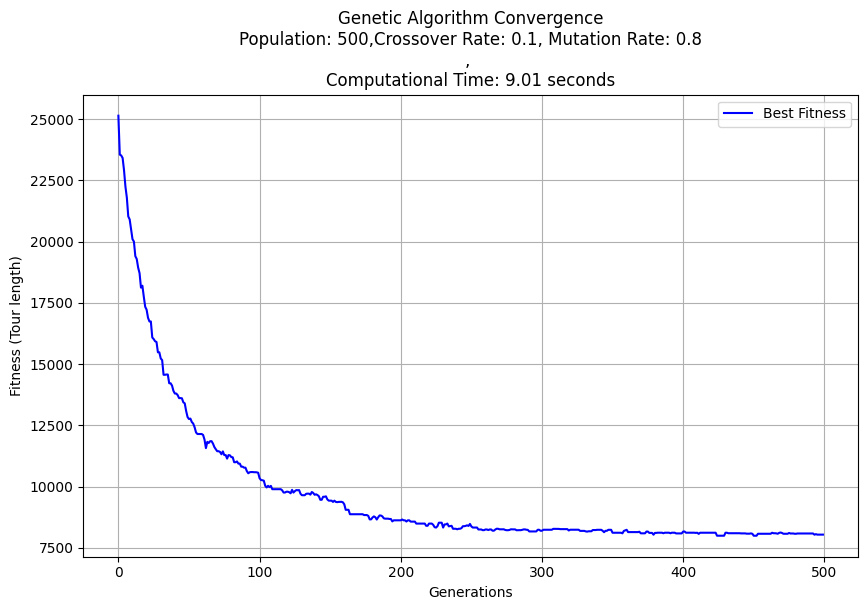

Generation 0: Best Fitness = 24826.95
Generation 1: Best Fitness = 24826.95
Generation 2: Best Fitness = 24061.13
Generation 3: Best Fitness = 23425.37
Generation 4: Best Fitness = 22917.24
Generation 5: Best Fitness = 22499.78
Generation 6: Best Fitness = 22459.68
Generation 7: Best Fitness = 20821.91
Generation 8: Best Fitness = 20777.29
Generation 9: Best Fitness = 20777.29
Generation 10: Best Fitness = 20623.15
Generation 11: Best Fitness = 19708.10
Generation 12: Best Fitness = 19186.72
Generation 13: Best Fitness = 19186.72
Generation 14: Best Fitness = 18858.20
Generation 15: Best Fitness = 18191.11
Generation 16: Best Fitness = 18114.75
Generation 17: Best Fitness = 17784.35
Generation 18: Best Fitness = 17574.75
Generation 19: Best Fitness = 17179.87
Generation 20: Best Fitness = 16606.60
Generation 21: Best Fitness = 16522.26
Generation 22: Best Fitness = 16225.18
Generation 23: Best Fitness = 15909.07
Generation 24: Best Fitness = 15807.56
Generation 25: Best Fitness = 15792

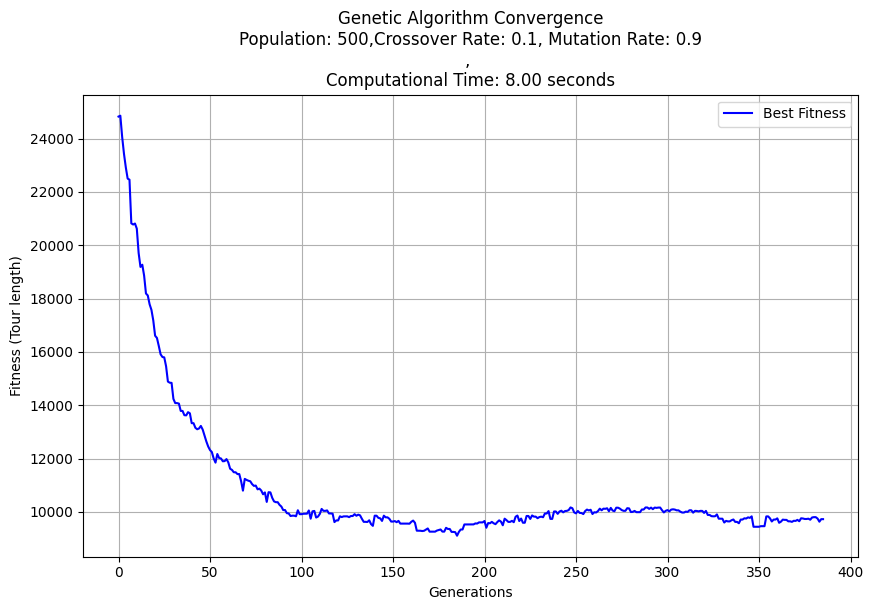

Generation 0: Best Fitness = 24346.31
Generation 1: Best Fitness = 23399.36
Generation 2: Best Fitness = 23399.36
Generation 3: Best Fitness = 22219.38
Generation 4: Best Fitness = 21695.44
Generation 5: Best Fitness = 21596.58
Generation 6: Best Fitness = 21032.10
Generation 7: Best Fitness = 20674.41
Generation 8: Best Fitness = 20674.41
Generation 9: Best Fitness = 20174.47
Generation 10: Best Fitness = 19670.28
Generation 11: Best Fitness = 19638.79
Generation 12: Best Fitness = 19097.14
Generation 13: Best Fitness = 18964.48
Generation 14: Best Fitness = 18402.14
Generation 15: Best Fitness = 18322.18
Generation 16: Best Fitness = 17295.77
Generation 17: Best Fitness = 17295.77
Generation 18: Best Fitness = 17160.17
Generation 19: Best Fitness = 16861.57
Generation 20: Best Fitness = 16466.60
Generation 21: Best Fitness = 16466.60
Generation 22: Best Fitness = 16426.84
Generation 23: Best Fitness = 16052.61
Generation 24: Best Fitness = 15975.89
Generation 25: Best Fitness = 15873

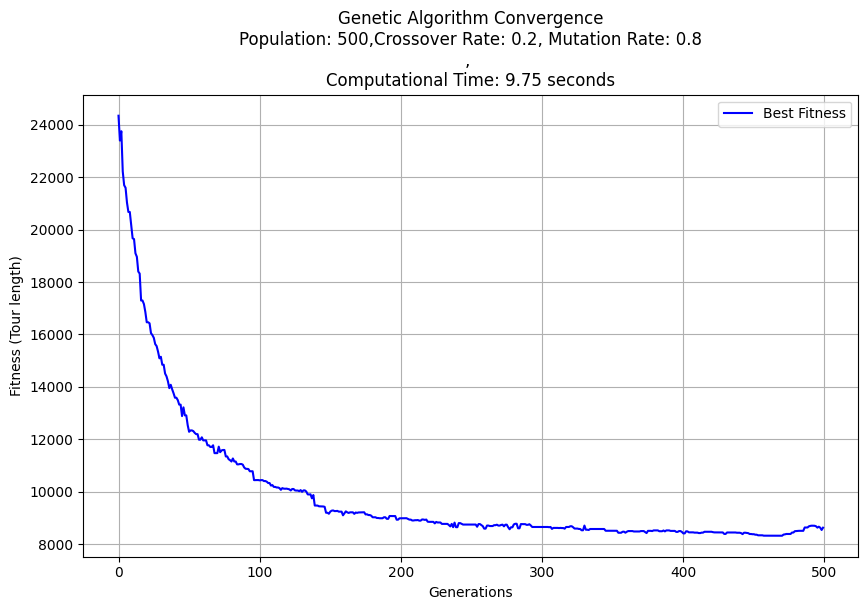

Generation 0: Best Fitness = 23934.86
Generation 1: Best Fitness = 23875.62
Generation 2: Best Fitness = 23340.60
Generation 3: Best Fitness = 23325.13
Generation 4: Best Fitness = 22773.45
Generation 5: Best Fitness = 22048.43
Generation 6: Best Fitness = 21720.28
Generation 7: Best Fitness = 21248.41
Generation 8: Best Fitness = 20964.81
Generation 9: Best Fitness = 20347.48
Generation 10: Best Fitness = 20347.48
Generation 11: Best Fitness = 19519.62
Generation 12: Best Fitness = 19235.17
Generation 13: Best Fitness = 18279.95
Generation 14: Best Fitness = 18279.95
Generation 15: Best Fitness = 17675.40
Generation 16: Best Fitness = 17675.40
Generation 17: Best Fitness = 17538.35
Generation 18: Best Fitness = 17143.01
Generation 19: Best Fitness = 17143.01
Generation 20: Best Fitness = 16808.45
Generation 21: Best Fitness = 16505.25
Generation 22: Best Fitness = 16396.15
Generation 23: Best Fitness = 16346.19
Generation 24: Best Fitness = 16174.86
Generation 25: Best Fitness = 16042

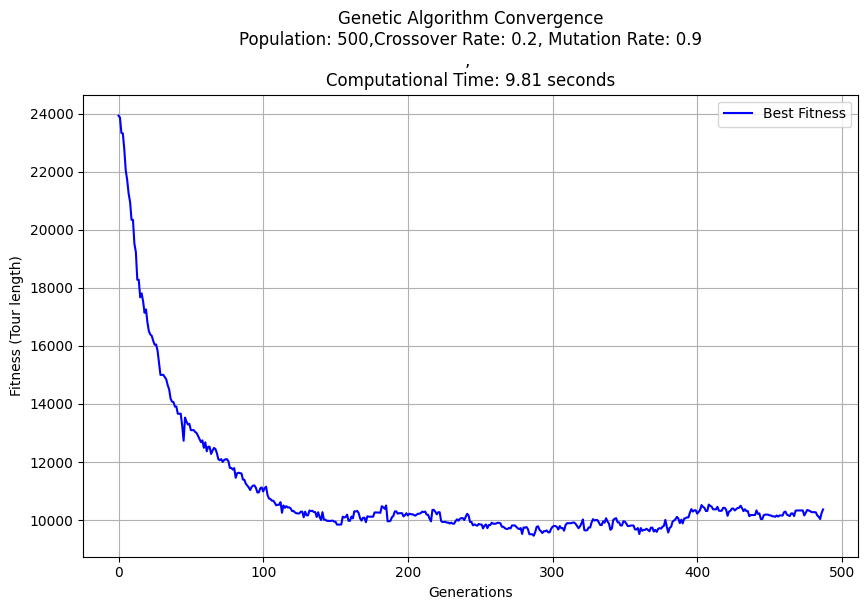

Generation 0: Best Fitness = 23858.99
Generation 1: Best Fitness = 23572.21
Generation 2: Best Fitness = 23404.23
Generation 3: Best Fitness = 22933.73
Generation 4: Best Fitness = 22535.17
Generation 5: Best Fitness = 22079.64
Generation 6: Best Fitness = 21533.13
Generation 7: Best Fitness = 21020.12
Generation 8: Best Fitness = 20625.08
Generation 9: Best Fitness = 20392.71
Generation 10: Best Fitness = 20166.39
Generation 11: Best Fitness = 19873.61
Generation 12: Best Fitness = 19339.23
Generation 13: Best Fitness = 19234.45
Generation 14: Best Fitness = 19039.19
Generation 15: Best Fitness = 18725.11
Generation 16: Best Fitness = 18337.52
Generation 17: Best Fitness = 17626.08
Generation 18: Best Fitness = 17354.90
Generation 19: Best Fitness = 16745.55
Generation 20: Best Fitness = 16687.73
Generation 21: Best Fitness = 16506.03
Generation 22: Best Fitness = 16338.27
Generation 23: Best Fitness = 15884.89
Generation 24: Best Fitness = 15855.01
Generation 25: Best Fitness = 15297

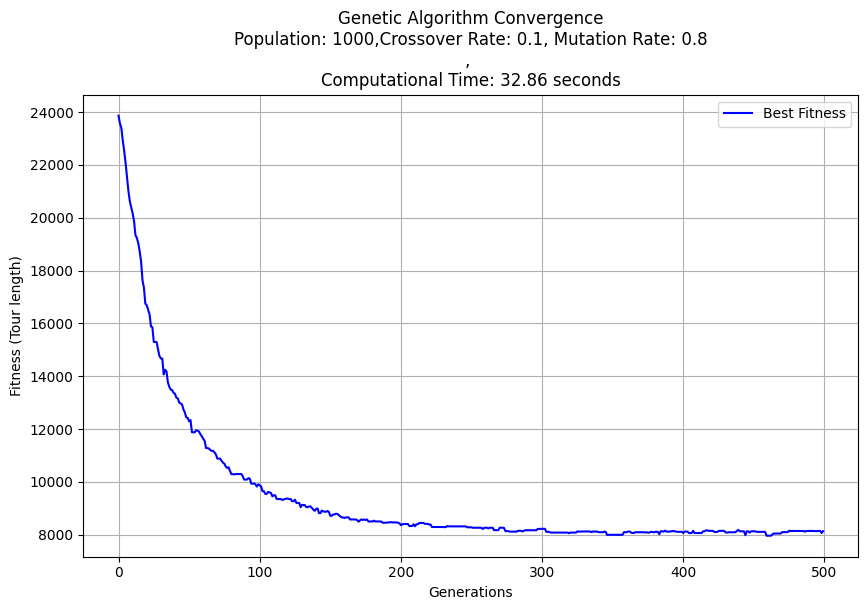

Generation 0: Best Fitness = 24046.16
Generation 1: Best Fitness = 23682.08
Generation 2: Best Fitness = 23141.61
Generation 3: Best Fitness = 22527.64
Generation 4: Best Fitness = 21869.62
Generation 5: Best Fitness = 21462.28
Generation 6: Best Fitness = 21462.28
Generation 7: Best Fitness = 21239.46
Generation 8: Best Fitness = 20581.55
Generation 9: Best Fitness = 19978.85
Generation 10: Best Fitness = 19934.52
Generation 11: Best Fitness = 19287.53
Generation 12: Best Fitness = 18893.01
Generation 13: Best Fitness = 18153.53
Generation 14: Best Fitness = 18153.53
Generation 15: Best Fitness = 17512.39
Generation 16: Best Fitness = 17269.71
Generation 17: Best Fitness = 16966.10
Generation 18: Best Fitness = 16624.62
Generation 19: Best Fitness = 16624.62
Generation 20: Best Fitness = 16412.16
Generation 21: Best Fitness = 16303.77
Generation 22: Best Fitness = 16245.00
Generation 23: Best Fitness = 16103.92
Generation 24: Best Fitness = 15841.61
Generation 25: Best Fitness = 15752

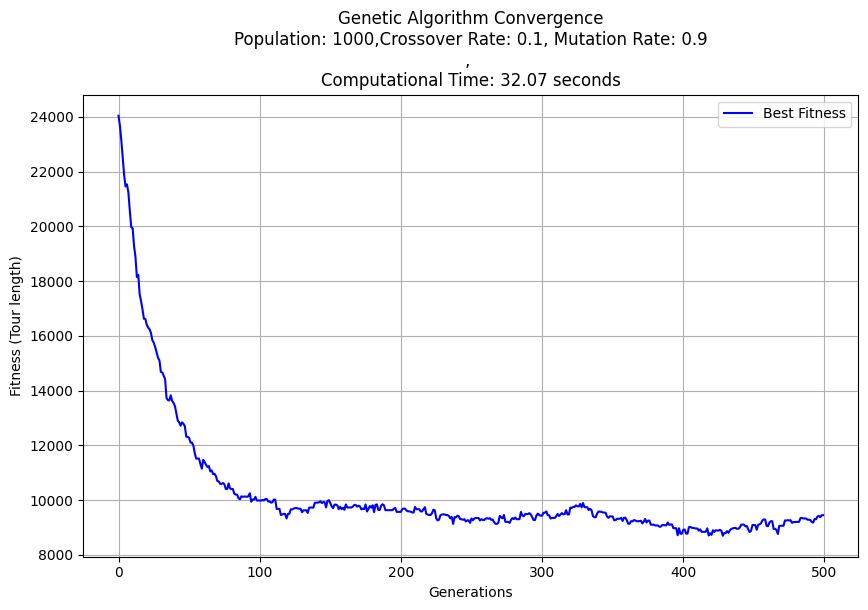

Generation 0: Best Fitness = 25335.44
Generation 1: Best Fitness = 23745.40
Generation 2: Best Fitness = 23392.36
Generation 3: Best Fitness = 22681.50
Generation 4: Best Fitness = 22501.39
Generation 5: Best Fitness = 21893.64
Generation 6: Best Fitness = 21719.44
Generation 7: Best Fitness = 20824.81
Generation 8: Best Fitness = 20691.53
Generation 9: Best Fitness = 20519.71
Generation 10: Best Fitness = 19586.01
Generation 11: Best Fitness = 19208.21
Generation 12: Best Fitness = 18535.56
Generation 13: Best Fitness = 18535.56
Generation 14: Best Fitness = 18258.26
Generation 15: Best Fitness = 17950.03
Generation 16: Best Fitness = 17793.75
Generation 17: Best Fitness = 17669.03
Generation 18: Best Fitness = 16990.12
Generation 19: Best Fitness = 16990.12
Generation 20: Best Fitness = 16348.53
Generation 21: Best Fitness = 16348.53
Generation 22: Best Fitness = 16298.15
Generation 23: Best Fitness = 15251.25
Generation 24: Best Fitness = 15251.25
Generation 25: Best Fitness = 15217

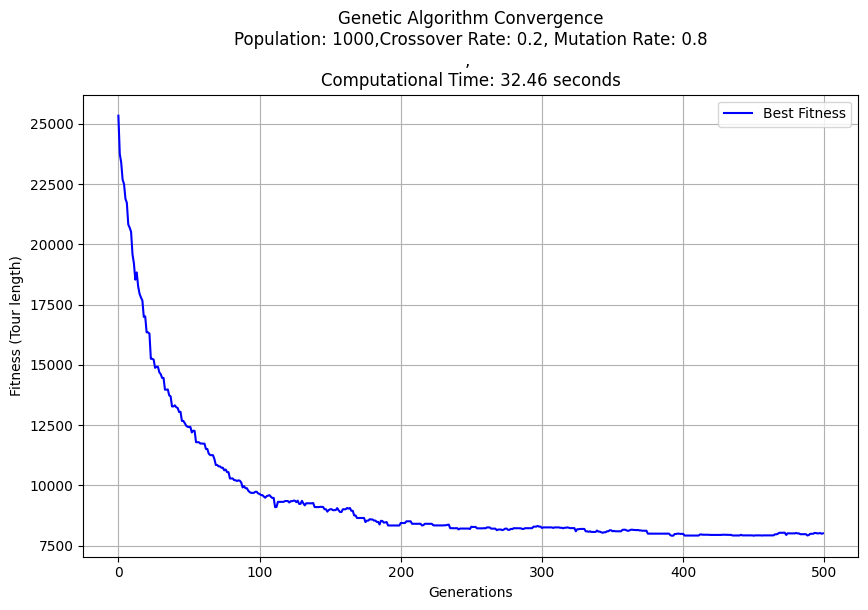

Generation 0: Best Fitness = 24200.50
Generation 1: Best Fitness = 23548.13
Generation 2: Best Fitness = 23355.36
Generation 3: Best Fitness = 21679.34
Generation 4: Best Fitness = 21369.35
Generation 5: Best Fitness = 20857.35
Generation 6: Best Fitness = 20351.23
Generation 7: Best Fitness = 20068.53
Generation 8: Best Fitness = 19231.65
Generation 9: Best Fitness = 19108.89
Generation 10: Best Fitness = 18739.22
Generation 11: Best Fitness = 18266.35
Generation 12: Best Fitness = 18013.09
Generation 13: Best Fitness = 17712.76
Generation 14: Best Fitness = 17289.66
Generation 15: Best Fitness = 17130.52
Generation 16: Best Fitness = 16849.92
Generation 17: Best Fitness = 16849.92
Generation 18: Best Fitness = 16366.43
Generation 19: Best Fitness = 16366.43
Generation 20: Best Fitness = 16167.93
Generation 21: Best Fitness = 15969.10
Generation 22: Best Fitness = 15721.69
Generation 23: Best Fitness = 14526.52
Generation 24: Best Fitness = 14526.52
Generation 25: Best Fitness = 14526

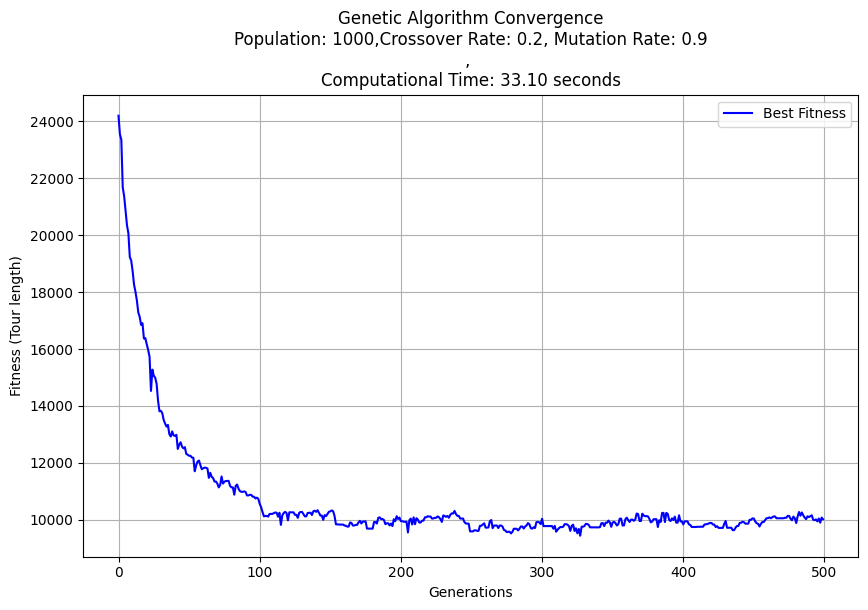

In [166]:
if __name__ == '__main__':
    filepath = "./TSP_files/berlin52.tsp"
    generations = 500
    tournament_size = 5
    parameter_sets = [
        (500, 0.1, 0.8),
        (500, 0.1, 0.9),
        (500, 0.2, 0.8),
        (500, 0.2, 0.9),
        (1000, 0.1, 0.8), 
        (1000, 0.1, 0.9), 
        (1000, 0.2, 0.8),
        (1000, 0.2, 0.9)
    ]
    
    plot_results(parameter_sets, filepath, generations, tournament_size)

# kroA100

Generation 0: Best Fitness = 146357.56
Generation 1: Best Fitness = 144271.99
Generation 2: Best Fitness = 130760.36
Generation 3: Best Fitness = 130760.36
Generation 4: Best Fitness = 130251.36
Generation 5: Best Fitness = 129876.11
Generation 6: Best Fitness = 128857.15
Generation 7: Best Fitness = 126598.34
Generation 8: Best Fitness = 126432.47
Generation 9: Best Fitness = 124327.21
Generation 10: Best Fitness = 122257.27
Generation 11: Best Fitness = 121165.09
Generation 12: Best Fitness = 119147.15
Generation 13: Best Fitness = 114860.49
Generation 14: Best Fitness = 113672.72
Generation 15: Best Fitness = 112269.09
Generation 16: Best Fitness = 109401.84
Generation 17: Best Fitness = 109246.91
Generation 18: Best Fitness = 107565.15
Generation 19: Best Fitness = 103080.60
Generation 20: Best Fitness = 102497.96
Generation 21: Best Fitness = 102042.53
Generation 22: Best Fitness = 101775.95
Generation 23: Best Fitness = 100864.48
Generation 24: Best Fitness = 99347.77
Generation 

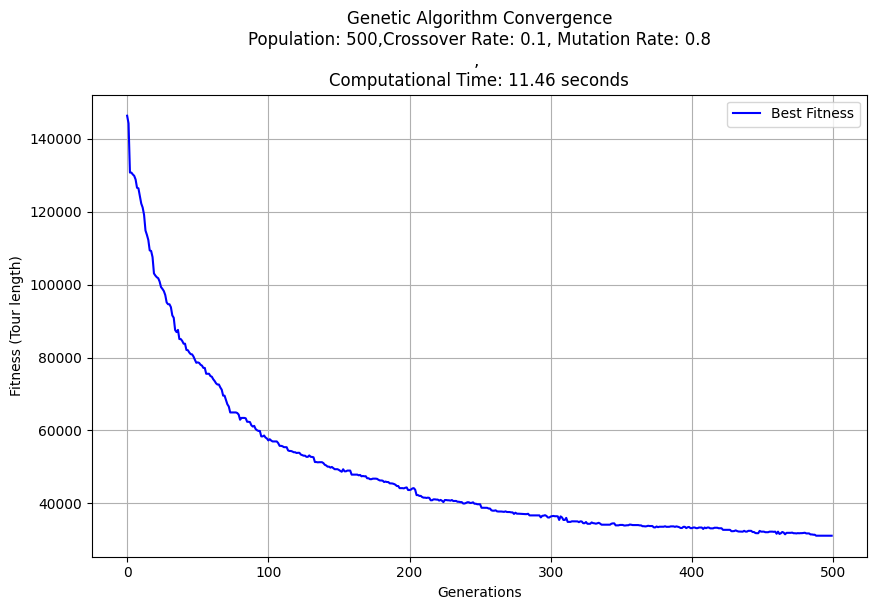

Generation 0: Best Fitness = 139292.83
Generation 1: Best Fitness = 136273.41
Generation 2: Best Fitness = 134797.82
Generation 3: Best Fitness = 134728.87
Generation 4: Best Fitness = 131048.57
Generation 5: Best Fitness = 127955.02
Generation 6: Best Fitness = 127229.17
Generation 7: Best Fitness = 123642.91
Generation 8: Best Fitness = 123604.10
Generation 9: Best Fitness = 121032.67
Generation 10: Best Fitness = 121032.67
Generation 11: Best Fitness = 116306.98
Generation 12: Best Fitness = 115483.88
Generation 13: Best Fitness = 110976.48
Generation 14: Best Fitness = 110485.06
Generation 15: Best Fitness = 110485.06
Generation 16: Best Fitness = 108623.16
Generation 17: Best Fitness = 106455.15
Generation 18: Best Fitness = 106160.09
Generation 19: Best Fitness = 105678.77
Generation 20: Best Fitness = 102803.64
Generation 21: Best Fitness = 101306.67
Generation 22: Best Fitness = 99575.02
Generation 23: Best Fitness = 99467.55
Generation 24: Best Fitness = 98546.36
Generation 25

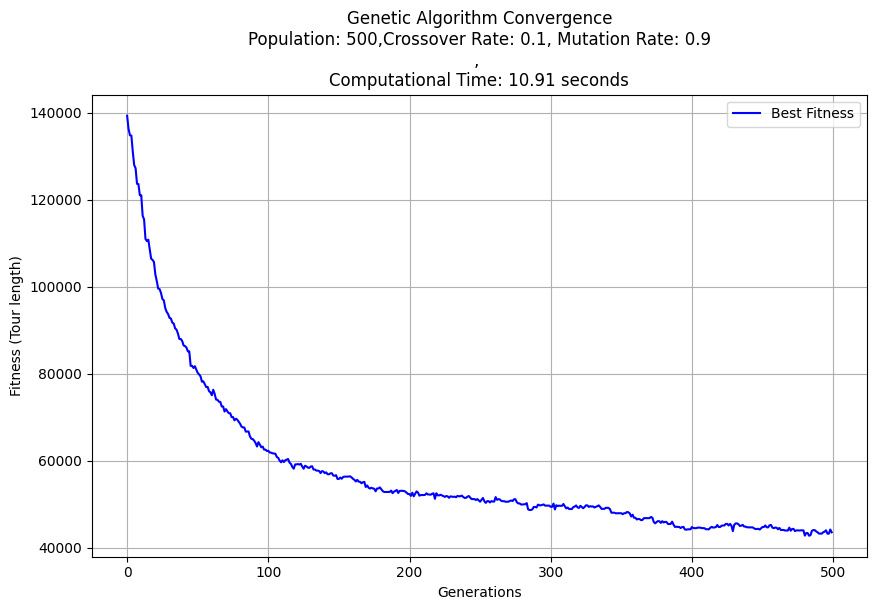

Generation 0: Best Fitness = 144596.97
Generation 1: Best Fitness = 141664.82
Generation 2: Best Fitness = 133213.79
Generation 3: Best Fitness = 133213.79
Generation 4: Best Fitness = 133213.79
Generation 5: Best Fitness = 131710.85
Generation 6: Best Fitness = 130039.64
Generation 7: Best Fitness = 127607.04
Generation 8: Best Fitness = 126561.80
Generation 9: Best Fitness = 122976.43
Generation 10: Best Fitness = 122976.43
Generation 11: Best Fitness = 118796.00
Generation 12: Best Fitness = 116952.82
Generation 13: Best Fitness = 115320.59
Generation 14: Best Fitness = 114167.16
Generation 15: Best Fitness = 113620.63
Generation 16: Best Fitness = 112999.57
Generation 17: Best Fitness = 112095.40
Generation 18: Best Fitness = 110241.88
Generation 19: Best Fitness = 107920.59
Generation 20: Best Fitness = 107322.16
Generation 21: Best Fitness = 106962.07
Generation 22: Best Fitness = 104614.50
Generation 23: Best Fitness = 103506.27
Generation 24: Best Fitness = 103469.77
Generation

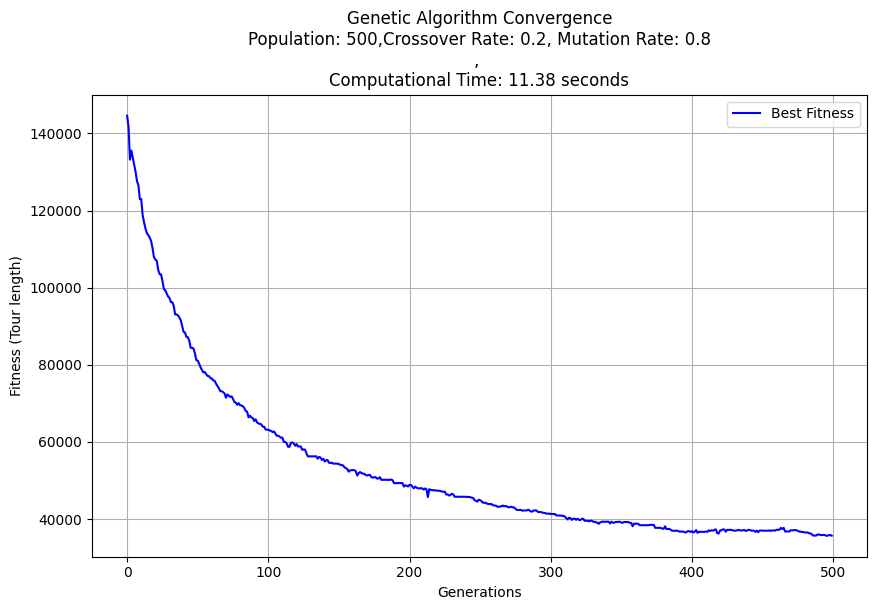

Generation 0: Best Fitness = 144599.98
Generation 1: Best Fitness = 141755.68
Generation 2: Best Fitness = 139506.39
Generation 3: Best Fitness = 139050.50
Generation 4: Best Fitness = 135810.74
Generation 5: Best Fitness = 132024.36
Generation 6: Best Fitness = 131726.25
Generation 7: Best Fitness = 128261.73
Generation 8: Best Fitness = 127701.26
Generation 9: Best Fitness = 125560.67
Generation 10: Best Fitness = 124416.69
Generation 11: Best Fitness = 123233.76
Generation 12: Best Fitness = 120503.44
Generation 13: Best Fitness = 119850.08
Generation 14: Best Fitness = 118477.97
Generation 15: Best Fitness = 116313.34
Generation 16: Best Fitness = 114099.81
Generation 17: Best Fitness = 112279.79
Generation 18: Best Fitness = 110921.72
Generation 19: Best Fitness = 108522.05
Generation 20: Best Fitness = 108482.02
Generation 21: Best Fitness = 106307.96
Generation 22: Best Fitness = 105102.23
Generation 23: Best Fitness = 103560.91
Generation 24: Best Fitness = 102044.37
Generation

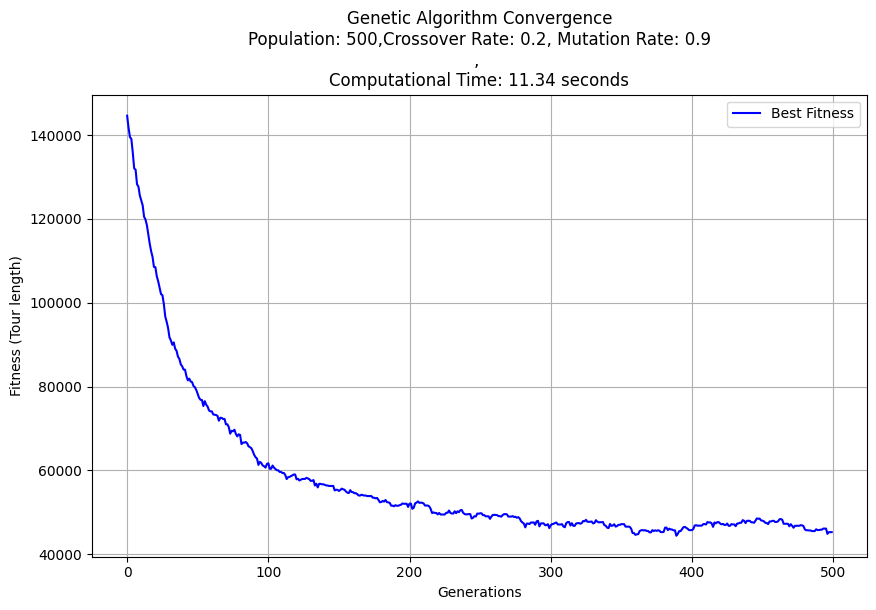

Generation 0: Best Fitness = 142591.09
Generation 1: Best Fitness = 142251.62
Generation 2: Best Fitness = 139372.25
Generation 3: Best Fitness = 132848.92
Generation 4: Best Fitness = 123268.31
Generation 5: Best Fitness = 123268.31
Generation 6: Best Fitness = 123268.31
Generation 7: Best Fitness = 123048.58
Generation 8: Best Fitness = 120822.49
Generation 9: Best Fitness = 119411.68
Generation 10: Best Fitness = 117846.35
Generation 11: Best Fitness = 114804.48
Generation 12: Best Fitness = 114063.48
Generation 13: Best Fitness = 113165.41
Generation 14: Best Fitness = 113165.41
Generation 15: Best Fitness = 112127.01
Generation 16: Best Fitness = 112115.49
Generation 17: Best Fitness = 109865.10
Generation 18: Best Fitness = 108444.97
Generation 19: Best Fitness = 105736.86
Generation 20: Best Fitness = 104069.42
Generation 21: Best Fitness = 103065.09
Generation 22: Best Fitness = 103065.09
Generation 23: Best Fitness = 102208.34
Generation 24: Best Fitness = 101358.78
Generation

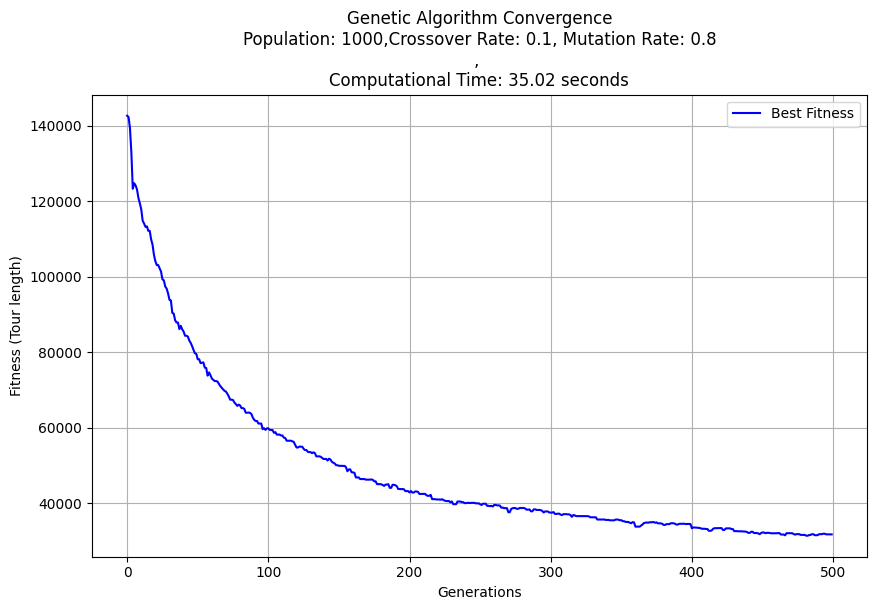

Generation 0: Best Fitness = 144063.09
Generation 1: Best Fitness = 142295.05
Generation 2: Best Fitness = 140003.39
Generation 3: Best Fitness = 138356.44
Generation 4: Best Fitness = 133542.18
Generation 5: Best Fitness = 132151.68
Generation 6: Best Fitness = 131576.18
Generation 7: Best Fitness = 127805.27
Generation 8: Best Fitness = 126588.61
Generation 9: Best Fitness = 125247.36
Generation 10: Best Fitness = 123778.47
Generation 11: Best Fitness = 123000.74
Generation 12: Best Fitness = 119968.52
Generation 13: Best Fitness = 119138.76
Generation 14: Best Fitness = 115249.40
Generation 15: Best Fitness = 113712.33
Generation 16: Best Fitness = 113277.71
Generation 17: Best Fitness = 111908.05
Generation 18: Best Fitness = 108345.44
Generation 19: Best Fitness = 108345.44
Generation 20: Best Fitness = 108082.47
Generation 21: Best Fitness = 106170.57
Generation 22: Best Fitness = 104619.67
Generation 23: Best Fitness = 102490.18
Generation 24: Best Fitness = 102490.18
Generation

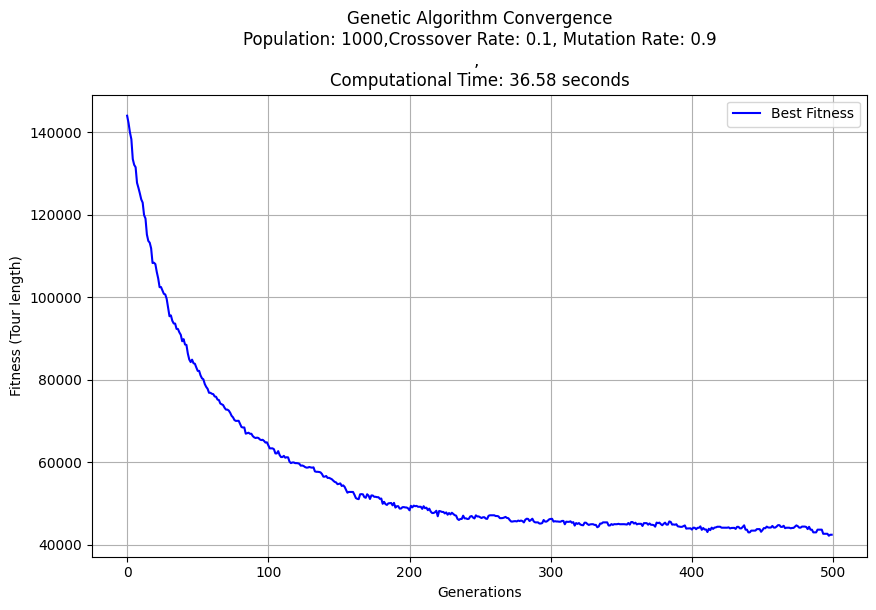

Generation 0: Best Fitness = 144684.11
Generation 1: Best Fitness = 143685.41
Generation 2: Best Fitness = 141958.82
Generation 3: Best Fitness = 140011.06
Generation 4: Best Fitness = 133934.80
Generation 5: Best Fitness = 132418.70
Generation 6: Best Fitness = 130783.67
Generation 7: Best Fitness = 128194.30
Generation 8: Best Fitness = 127019.07
Generation 9: Best Fitness = 123529.59
Generation 10: Best Fitness = 123403.94
Generation 11: Best Fitness = 120640.54
Generation 12: Best Fitness = 120308.20
Generation 13: Best Fitness = 117706.81
Generation 14: Best Fitness = 111739.39
Generation 15: Best Fitness = 111120.96
Generation 16: Best Fitness = 111106.38
Generation 17: Best Fitness = 108836.34
Generation 18: Best Fitness = 108836.34
Generation 19: Best Fitness = 106582.45
Generation 20: Best Fitness = 102866.12
Generation 21: Best Fitness = 102168.00
Generation 22: Best Fitness = 101731.33
Generation 23: Best Fitness = 101426.38
Generation 24: Best Fitness = 100067.41
Generation

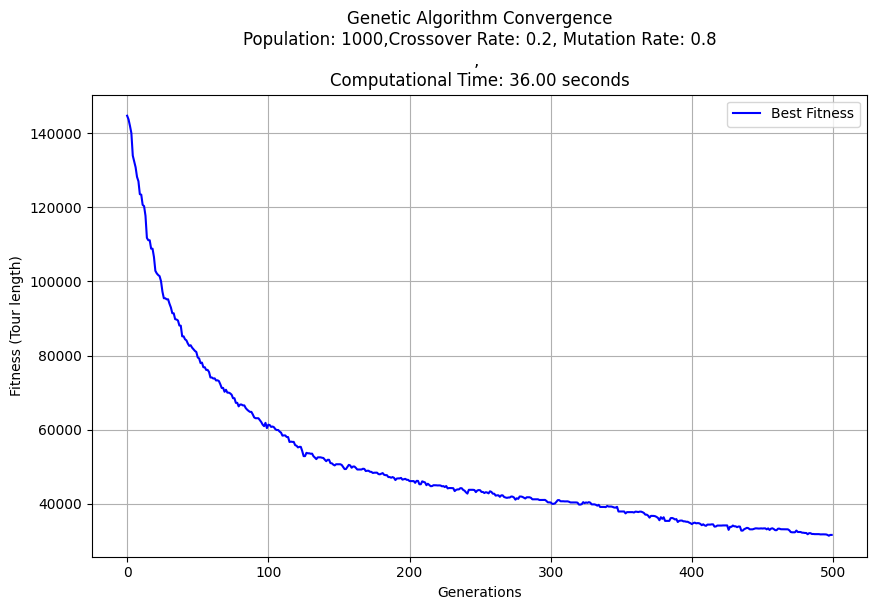

Generation 0: Best Fitness = 147262.99
Generation 1: Best Fitness = 144272.35
Generation 2: Best Fitness = 142267.03
Generation 3: Best Fitness = 135810.75
Generation 4: Best Fitness = 127668.68
Generation 5: Best Fitness = 127259.17
Generation 6: Best Fitness = 126924.85
Generation 7: Best Fitness = 125258.33
Generation 8: Best Fitness = 123858.50
Generation 9: Best Fitness = 121614.48
Generation 10: Best Fitness = 119511.72
Generation 11: Best Fitness = 117325.17
Generation 12: Best Fitness = 115694.51
Generation 13: Best Fitness = 115431.80
Generation 14: Best Fitness = 114715.78
Generation 15: Best Fitness = 113848.20
Generation 16: Best Fitness = 111883.65
Generation 17: Best Fitness = 110091.45
Generation 18: Best Fitness = 109333.74
Generation 19: Best Fitness = 106565.78
Generation 20: Best Fitness = 105697.20
Generation 21: Best Fitness = 105296.40
Generation 22: Best Fitness = 103731.92
Generation 23: Best Fitness = 103450.82
Generation 24: Best Fitness = 100035.04
Generation

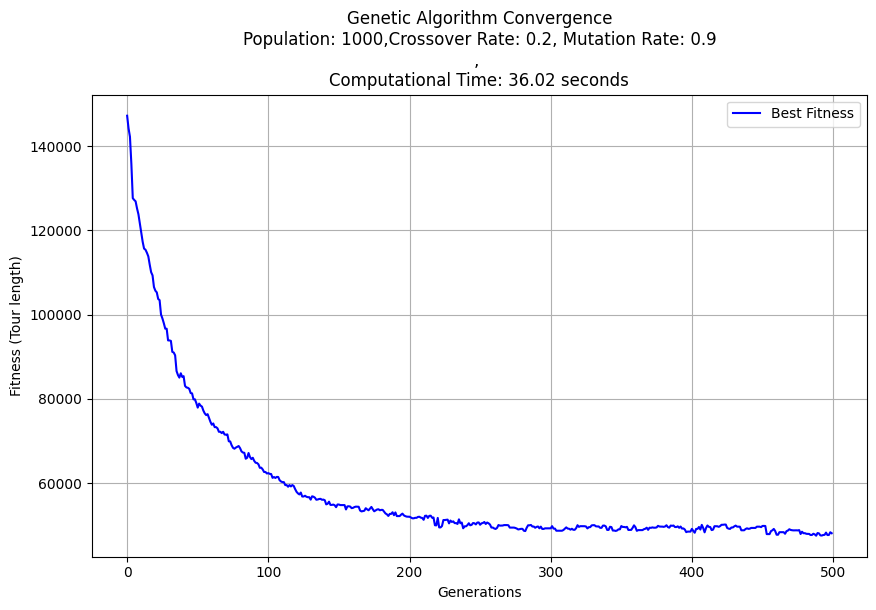

In [169]:
if __name__ == '__main__':
    filepath = "./TSP_files/kroA100.tsp"
    generations = 500
    tournament_size = 5
    parameter_sets = [
        (500, 0.1, 0.8),
        (500, 0.1, 0.9),
        (500, 0.2, 0.8),
        (500, 0.2, 0.9),
        (1000, 0.1, 0.8), 
        (1000, 0.1, 0.9), 
        (1000, 0.2, 0.8),
        (1000, 0.2, 0.9)
    ]
    
    plot_results(parameter_sets, filepath, generations, tournament_size)

# Pr1002

Generation 0: Best Fitness = 6228140.44
Generation 1: Best Fitness = 6205988.50
Generation 2: Best Fitness = 6127673.95
Generation 3: Best Fitness = 6124411.71
Generation 4: Best Fitness = 6089139.98
Generation 5: Best Fitness = 6068220.84
Generation 6: Best Fitness = 6063084.49
Generation 7: Best Fitness = 6060106.31
Generation 8: Best Fitness = 6042356.38
Generation 9: Best Fitness = 6023617.35
Generation 10: Best Fitness = 6023617.35
Generation 11: Best Fitness = 5998189.68
Generation 12: Best Fitness = 5992144.77
Generation 13: Best Fitness = 5987220.39
Generation 14: Best Fitness = 5980037.11
Generation 15: Best Fitness = 5968203.69
Generation 16: Best Fitness = 5943168.90
Generation 17: Best Fitness = 5935820.74
Generation 18: Best Fitness = 5896357.01
Generation 19: Best Fitness = 5886838.53
Generation 20: Best Fitness = 5879650.99
Generation 21: Best Fitness = 5867773.74
Generation 22: Best Fitness = 5857240.58
Generation 23: Best Fitness = 5851622.09
Generation 24: Best Fitnes

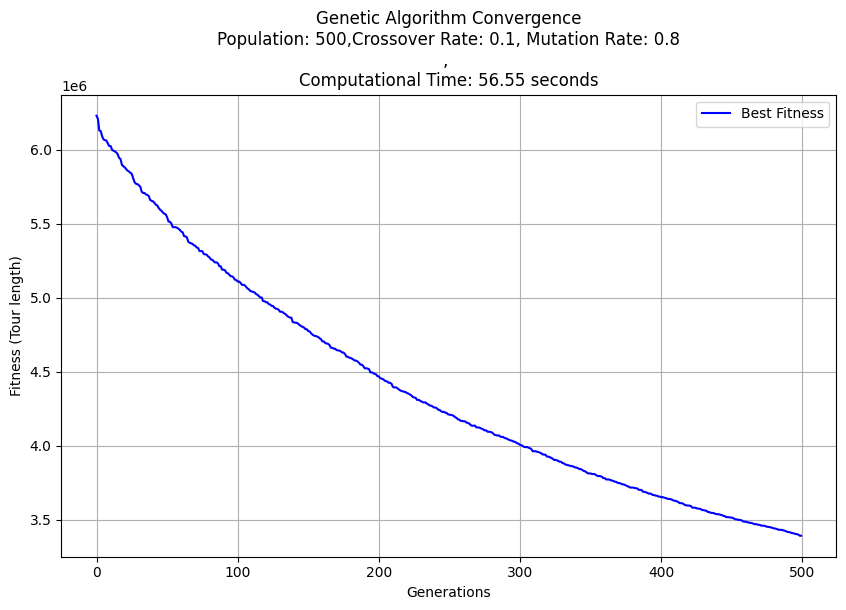

Generation 0: Best Fitness = 6187012.67
Generation 1: Best Fitness = 6185158.40
Generation 2: Best Fitness = 6172263.66
Generation 3: Best Fitness = 6146204.35
Generation 4: Best Fitness = 6094495.64
Generation 5: Best Fitness = 6033328.32
Generation 6: Best Fitness = 6029739.58
Generation 7: Best Fitness = 6004352.55
Generation 8: Best Fitness = 5970442.30
Generation 9: Best Fitness = 5970108.31
Generation 10: Best Fitness = 5960291.05
Generation 11: Best Fitness = 5947616.59
Generation 12: Best Fitness = 5946327.87
Generation 13: Best Fitness = 5918917.10
Generation 14: Best Fitness = 5916100.21
Generation 15: Best Fitness = 5895005.78
Generation 16: Best Fitness = 5889911.48
Generation 17: Best Fitness = 5881736.52
Generation 18: Best Fitness = 5879053.40
Generation 19: Best Fitness = 5839454.15
Generation 20: Best Fitness = 5837992.29
Generation 21: Best Fitness = 5805733.08
Generation 22: Best Fitness = 5800855.70
Generation 23: Best Fitness = 5800380.00
Generation 24: Best Fitnes

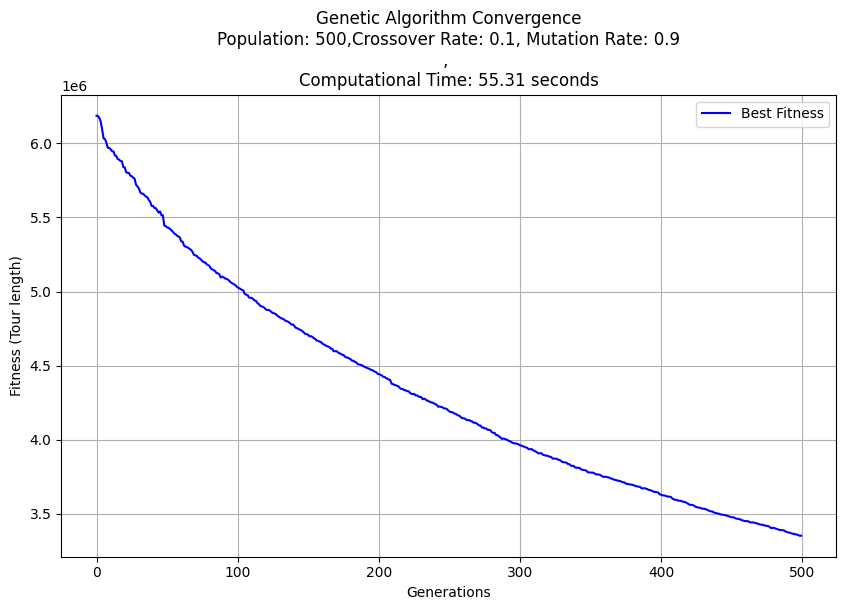

Generation 0: Best Fitness = 6202293.26
Generation 1: Best Fitness = 6199154.59
Generation 2: Best Fitness = 6149797.85
Generation 3: Best Fitness = 6141625.26
Generation 4: Best Fitness = 6082151.50
Generation 5: Best Fitness = 6033374.76
Generation 6: Best Fitness = 6030192.66
Generation 7: Best Fitness = 6022093.25
Generation 8: Best Fitness = 5979391.90
Generation 9: Best Fitness = 5968502.18
Generation 10: Best Fitness = 5963003.70
Generation 11: Best Fitness = 5939547.21
Generation 12: Best Fitness = 5939547.21
Generation 13: Best Fitness = 5919980.32
Generation 14: Best Fitness = 5905955.86
Generation 15: Best Fitness = 5902701.46
Generation 16: Best Fitness = 5900392.31
Generation 17: Best Fitness = 5846458.10
Generation 18: Best Fitness = 5826292.85
Generation 19: Best Fitness = 5812982.79
Generation 20: Best Fitness = 5810945.82
Generation 21: Best Fitness = 5783151.98
Generation 22: Best Fitness = 5777821.05
Generation 23: Best Fitness = 5767635.07
Generation 24: Best Fitnes

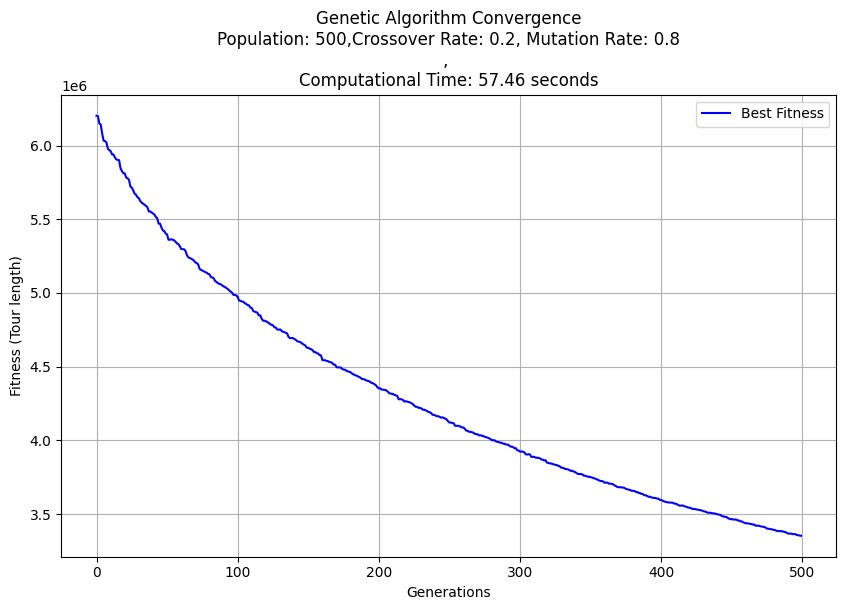

Generation 0: Best Fitness = 6192075.92
Generation 1: Best Fitness = 6186500.08
Generation 2: Best Fitness = 6156315.07
Generation 3: Best Fitness = 6127263.95
Generation 4: Best Fitness = 6126892.12
Generation 5: Best Fitness = 6074267.37
Generation 6: Best Fitness = 6056151.19
Generation 7: Best Fitness = 6002734.09
Generation 8: Best Fitness = 5993021.00
Generation 9: Best Fitness = 5986701.11
Generation 10: Best Fitness = 5964237.09
Generation 11: Best Fitness = 5937026.00
Generation 12: Best Fitness = 5930515.72
Generation 13: Best Fitness = 5908625.04
Generation 14: Best Fitness = 5868688.04
Generation 15: Best Fitness = 5867466.97
Generation 16: Best Fitness = 5856206.79
Generation 17: Best Fitness = 5827345.98
Generation 18: Best Fitness = 5818071.87
Generation 19: Best Fitness = 5814246.36
Generation 20: Best Fitness = 5744452.93
Generation 21: Best Fitness = 5734604.95
Generation 22: Best Fitness = 5734604.95
Generation 23: Best Fitness = 5702489.41
Generation 24: Best Fitnes

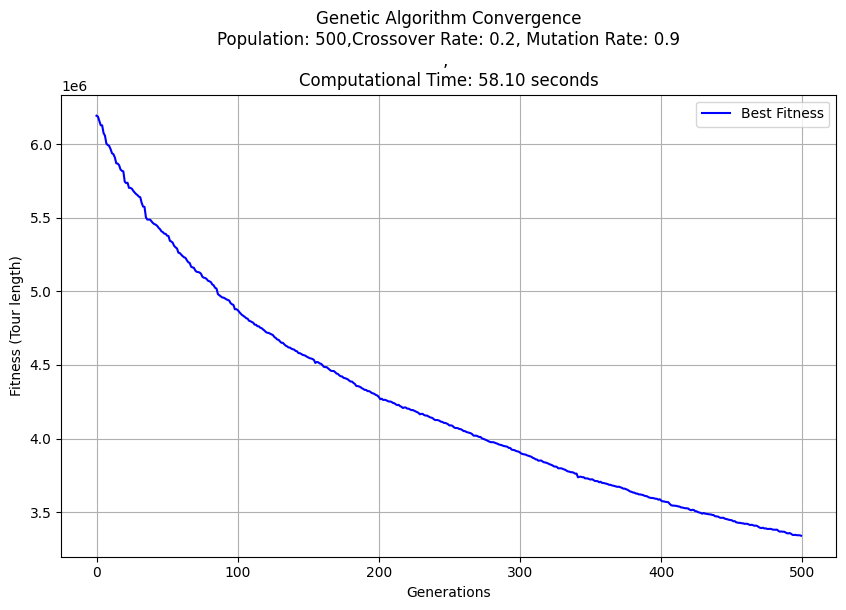

Generation 0: Best Fitness = 6154605.25
Generation 1: Best Fitness = 6154605.25
Generation 2: Best Fitness = 6087387.65
Generation 3: Best Fitness = 6078443.23
Generation 4: Best Fitness = 6071502.71
Generation 5: Best Fitness = 6048059.96
Generation 6: Best Fitness = 6048059.96
Generation 7: Best Fitness = 6042934.35
Generation 8: Best Fitness = 6003585.62
Generation 9: Best Fitness = 6003585.62
Generation 10: Best Fitness = 5980419.43
Generation 11: Best Fitness = 5968114.05
Generation 12: Best Fitness = 5958112.87
Generation 13: Best Fitness = 5948866.02
Generation 14: Best Fitness = 5935848.07
Generation 15: Best Fitness = 5868775.39
Generation 16: Best Fitness = 5865793.53
Generation 17: Best Fitness = 5856489.30
Generation 18: Best Fitness = 5849376.68
Generation 19: Best Fitness = 5820320.14
Generation 20: Best Fitness = 5810645.12
Generation 21: Best Fitness = 5810444.32
Generation 22: Best Fitness = 5806354.71
Generation 23: Best Fitness = 5796094.14
Generation 24: Best Fitnes

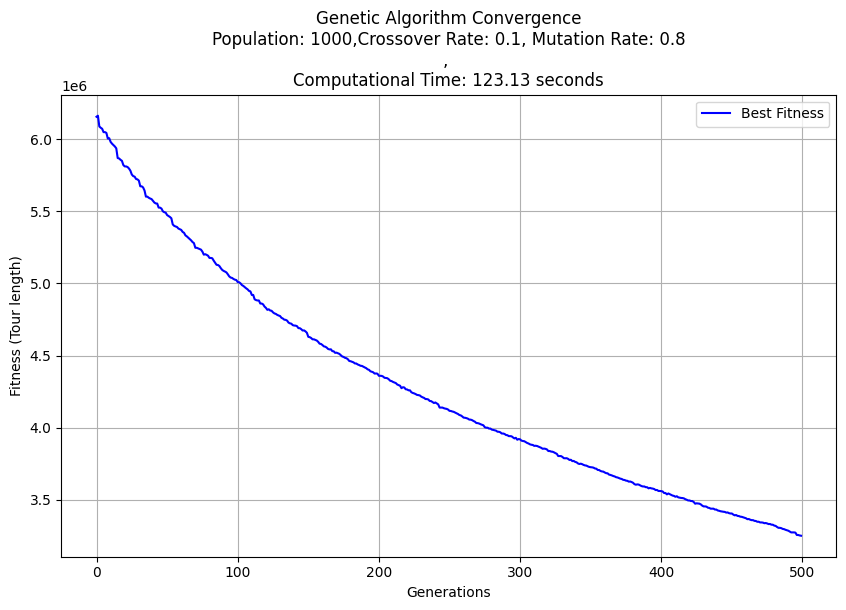

Generation 0: Best Fitness = 6137271.38
Generation 1: Best Fitness = 6127588.56
Generation 2: Best Fitness = 6126083.04
Generation 3: Best Fitness = 6115042.14
Generation 4: Best Fitness = 6081907.92
Generation 5: Best Fitness = 6074552.67
Generation 6: Best Fitness = 6056349.86
Generation 7: Best Fitness = 6056349.86
Generation 8: Best Fitness = 6041003.07
Generation 9: Best Fitness = 5967299.88
Generation 10: Best Fitness = 5963366.74
Generation 11: Best Fitness = 5958124.10
Generation 12: Best Fitness = 5931467.58
Generation 13: Best Fitness = 5897863.87
Generation 14: Best Fitness = 5897863.87
Generation 15: Best Fitness = 5881587.01
Generation 16: Best Fitness = 5861861.99
Generation 17: Best Fitness = 5840982.63
Generation 18: Best Fitness = 5840029.26
Generation 19: Best Fitness = 5823611.62
Generation 20: Best Fitness = 5821413.30
Generation 21: Best Fitness = 5809918.87
Generation 22: Best Fitness = 5761162.76
Generation 23: Best Fitness = 5758773.57
Generation 24: Best Fitnes

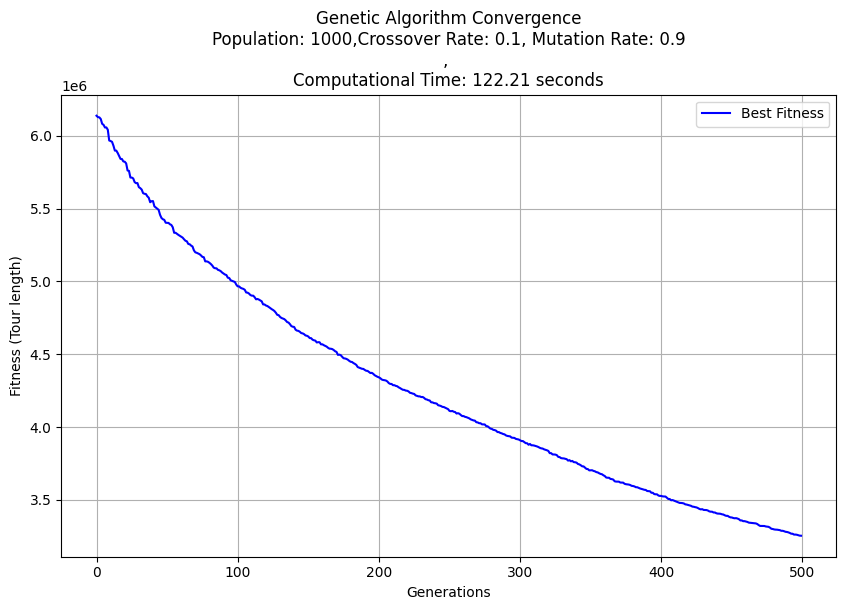

Generation 0: Best Fitness = 6137599.72
Generation 1: Best Fitness = 6131536.20
Generation 2: Best Fitness = 6083993.93
Generation 3: Best Fitness = 6075980.39
Generation 4: Best Fitness = 6062516.95
Generation 5: Best Fitness = 6027299.23
Generation 6: Best Fitness = 5970429.22
Generation 7: Best Fitness = 5963335.26
Generation 8: Best Fitness = 5934839.98
Generation 9: Best Fitness = 5918397.27
Generation 10: Best Fitness = 5918397.27
Generation 11: Best Fitness = 5913489.48
Generation 12: Best Fitness = 5900365.85
Generation 13: Best Fitness = 5892723.60
Generation 14: Best Fitness = 5827345.63
Generation 15: Best Fitness = 5825356.46
Generation 16: Best Fitness = 5817130.58
Generation 17: Best Fitness = 5815304.32
Generation 18: Best Fitness = 5809253.52
Generation 19: Best Fitness = 5767682.76
Generation 20: Best Fitness = 5766127.71
Generation 21: Best Fitness = 5746325.00
Generation 22: Best Fitness = 5719806.88
Generation 23: Best Fitness = 5714468.60
Generation 24: Best Fitnes

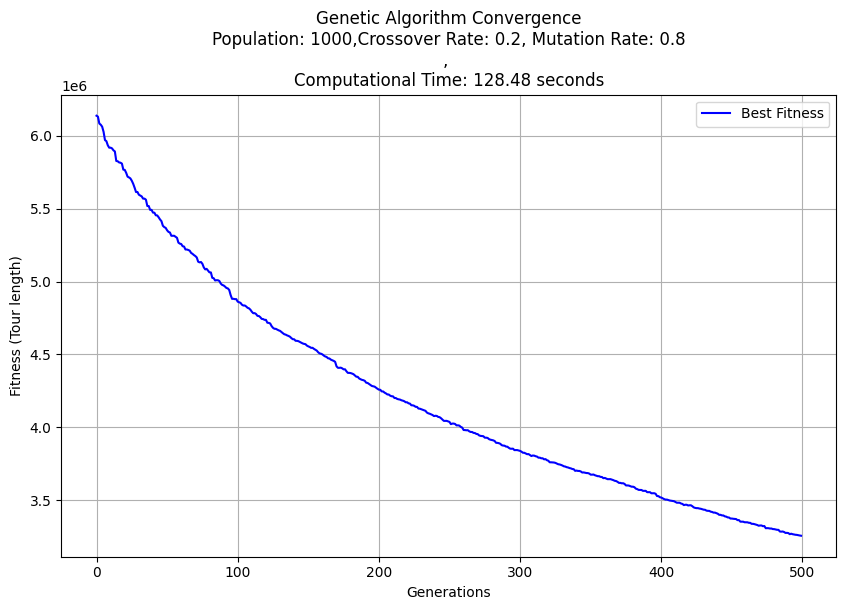

Generation 0: Best Fitness = 6198682.80
Generation 1: Best Fitness = 6135338.92
Generation 2: Best Fitness = 6109279.22
Generation 3: Best Fitness = 6097540.14
Generation 4: Best Fitness = 6069192.35
Generation 5: Best Fitness = 5995227.14
Generation 6: Best Fitness = 5983692.35
Generation 7: Best Fitness = 5980259.08
Generation 8: Best Fitness = 5974067.08
Generation 9: Best Fitness = 5968105.17
Generation 10: Best Fitness = 5957597.18
Generation 11: Best Fitness = 5917838.69
Generation 12: Best Fitness = 5899164.70
Generation 13: Best Fitness = 5898919.73
Generation 14: Best Fitness = 5891816.35
Generation 15: Best Fitness = 5863189.77
Generation 16: Best Fitness = 5856400.22
Generation 17: Best Fitness = 5834354.01
Generation 18: Best Fitness = 5809708.72
Generation 19: Best Fitness = 5777202.32
Generation 20: Best Fitness = 5773168.48
Generation 21: Best Fitness = 5767350.12
Generation 22: Best Fitness = 5742992.82
Generation 23: Best Fitness = 5735267.61
Generation 24: Best Fitnes

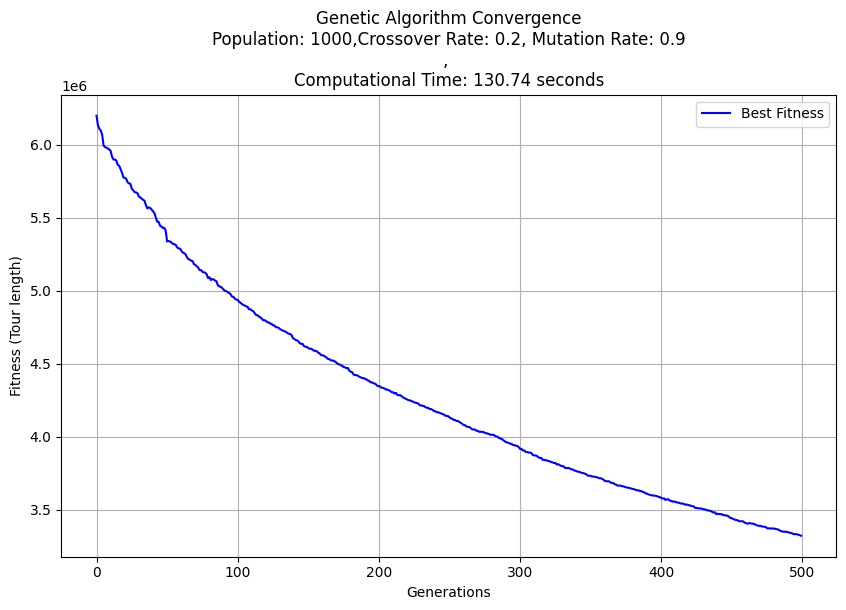

In [170]:
if __name__ == '__main__':
    filepath = "./TSP_files/pr1002.tsp"
    generations = 500
    tournament_size = 5
    parameter_sets = [
        (500, 0.1, 0.8),
        (500, 0.1, 0.9),
        (500, 0.2, 0.8),
        (500, 0.2, 0.9),
        (1000, 0.1, 0.8), 
        (1000, 0.1, 0.9), 
        (1000, 0.2, 0.8),
        (1000, 0.2, 0.9)
    ]
    
    plot_results(parameter_sets, filepath, generations, tournament_size)

 I want to run a test for the best performing parameter on the large dataset with over 500 gens to see if it can improve further as it doesn't seem to converge to a local maxima with 500 generations

Generation 0: Best Fitness = 140312.10
Generation 1: Best Fitness = 139515.73
Generation 2: Best Fitness = 139063.82
Generation 3: Best Fitness = 136212.31
Generation 4: Best Fitness = 136152.65
Generation 5: Best Fitness = 133624.24
Generation 6: Best Fitness = 130599.78
Generation 7: Best Fitness = 128808.87
Generation 8: Best Fitness = 127860.39
Generation 9: Best Fitness = 126005.00
Generation 10: Best Fitness = 123321.77
Generation 11: Best Fitness = 118006.31
Generation 12: Best Fitness = 118006.31
Generation 13: Best Fitness = 117273.54
Generation 14: Best Fitness = 115474.29
Generation 15: Best Fitness = 115262.68
Generation 16: Best Fitness = 114745.45
Generation 17: Best Fitness = 111398.81
Generation 18: Best Fitness = 111202.77
Generation 19: Best Fitness = 109530.59
Generation 20: Best Fitness = 109325.86
Generation 21: Best Fitness = 107249.26
Generation 22: Best Fitness = 105512.60
Generation 23: Best Fitness = 102763.35
Generation 24: Best Fitness = 102763.35
Generation

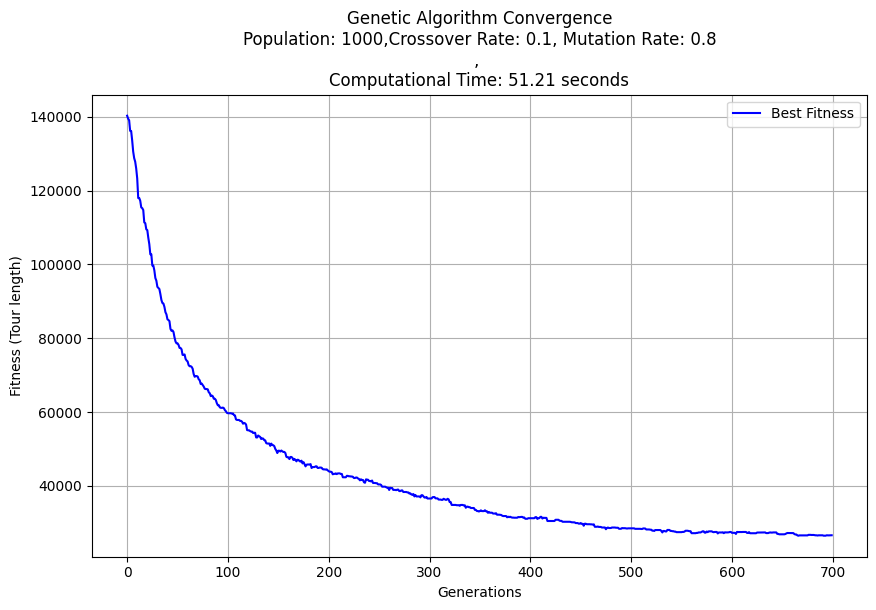

In [173]:
if __name__ == '__main__':
    filepath = "./TSP_files/kroA100.tsp"
    generations = 700
    tournament_size = 5
    parameter_sets = [
        # (500, 0.1, 0.8),
        # (500, 0.1, 0.9),
        # (500, 0.2, 0.8),
        # (500, 0.2, 0.9),
        (1000, 0.1, 0.8), # Best performing 
        # (1000, 0.1, 0.9), 
        # (1000, 0.2, 0.8),
        # (1000, 0.2, 0.9)
    ]
    
    plot_results(parameter_sets, filepath, generations, tournament_size)

Generation 0: Best Fitness = 6113266.94
Generation 1: Best Fitness = 6111114.08
Generation 2: Best Fitness = 6105689.88
Generation 3: Best Fitness = 6094803.73
Generation 4: Best Fitness = 6055242.31
Generation 5: Best Fitness = 6029895.70
Generation 6: Best Fitness = 6029895.70
Generation 7: Best Fitness = 6016101.06
Generation 8: Best Fitness = 5929667.56
Generation 9: Best Fitness = 5927863.42
Generation 10: Best Fitness = 5915257.24
Generation 11: Best Fitness = 5906717.14
Generation 12: Best Fitness = 5836133.78
Generation 13: Best Fitness = 5836133.78
Generation 14: Best Fitness = 5833872.79
Generation 15: Best Fitness = 5825417.99
Generation 16: Best Fitness = 5816964.64
Generation 17: Best Fitness = 5809573.93
Generation 18: Best Fitness = 5779222.92
Generation 19: Best Fitness = 5779222.92
Generation 20: Best Fitness = 5767522.53
Generation 21: Best Fitness = 5760520.60
Generation 22: Best Fitness = 5726742.92
Generation 23: Best Fitness = 5723695.25
Generation 24: Best Fitnes

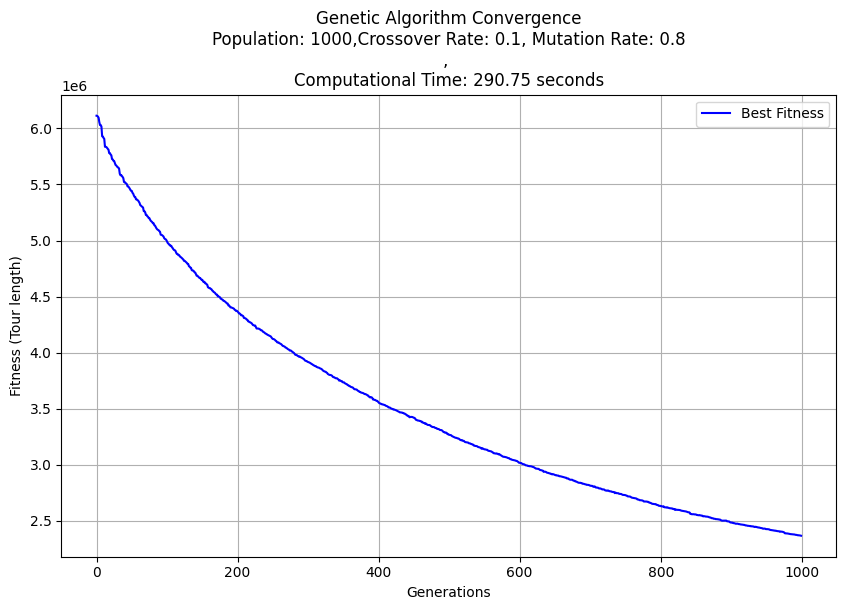

In [177]:
if __name__ == '__main__':
    filepath = "./TSP_files/pr1002.tsp"
    generations = 1000
    tournament_size = 5
    parameter_sets = [
        # (500, 0.1, 0.8),
        # (500, 0.1, 0.9),
        # (500, 0.2, 0.8),
        # (500, 0.2, 0.9),
        (1000, 0.1, 0.8), # Best performing 
        # (1000, 0.1, 0.9), 
        # (1000, 0.2, 0.8),
        # (1000, 0.2, 0.9)
    ]
    
    plot_results(parameter_sets, filepath, generations, tournament_size)

# Experiments

### Testing different parameters

In [145]:
def population_params():
    # Define the parameter ranges for population size, mutation rates, and crossover rates
    pop_sizes = [100, 250, 500, 750, 1000]
    mutation_rates = [0.02]  # Constant mutation rate
    crossover_rates = [0.8]  # Constant crossover rate
    return pop_sizes, mutation_rates, crossover_rates

def crossover_params():
    # Define the parameter ranges for crossover rates
    pop_sizes = [250]  # Fixed population size
    crossover_rates = [0.6, 0.7, 0.8, 0.9]  # Varying crossover rates
    mutation_rates = [0.02]  # Constant mutation rate
    return pop_sizes, mutation_rates, crossover_rates

def mutation_params():
    # Define the parameter ranges for mutation rates
    pop_sizes = [250]  # Fixed population size
    crossover_rates = [0.8]  # Constant crossover rate
    mutation_rates = [0, 0.01, 0.02, 0.05, 0.1, 0.2]  # Varying mutation rates
    return pop_sizes, mutation_rates, crossover_rates

### Experiment for varying parameter values

In [132]:
import itertools

# Function to iterate through combinations of parameters
def run_experiment(filepath, generations, tournament_size, pop_sizes, mutation_rates, crossover_rates):
    # Generate all possible combinations of the varying parameters
    parameter_sets = list(itertools.product(pop_sizes, crossover_rates, mutation_rates))

    all_fitness_histories = []

    for params in parameter_sets:
        population_size, mutation_rate, crossover_rate = params
        best_solution, best_fitness, fitness_history, elapsed_time = genetic_algorithm(
            filepath, generations, population_size, mutation_rate, crossover_rate, tournament_size
        )
        all_fitness_histories.append((params, fitness_history))

    # Plot results
    plt.figure(figsize=(10, 6))
    for params, fitness_history in all_fitness_histories:
        label = f"Pop: {params[0]}, Cross: {params[2]}, Mut: {params[1]}"
        plt.plot(range(len(fitness_history)), fitness_history, label=label)
    
    plt.ylabel("Fitness (Tour length)")
    plt.xlabel("Generations")
    plt.title("Genetic Algorithm Convergence for Different Parameters")
    plt.legend()
    plt.grid(True)
    plt.show()

## Run the parameter varying test

Generation 0: Best Fitness = 25672.54
Generation 1: Best Fitness = 24209.69
Generation 2: Best Fitness = 24183.78
Generation 3: Best Fitness = 21487.61
Generation 4: Best Fitness = 21487.61
Generation 5: Best Fitness = 21487.61
Generation 6: Best Fitness = 21396.77
Generation 7: Best Fitness = 20979.95
Generation 8: Best Fitness = 20476.12
Generation 9: Best Fitness = 20309.59
Generation 10: Best Fitness = 19831.47
Generation 11: Best Fitness = 19831.47
Generation 12: Best Fitness = 19580.13
Generation 13: Best Fitness = 19437.26
Generation 14: Best Fitness = 19389.90
Generation 15: Best Fitness = 19312.09
Generation 16: Best Fitness = 19223.37
Generation 17: Best Fitness = 18922.49
Generation 18: Best Fitness = 18922.49
Generation 19: Best Fitness = 18627.95
Generation 20: Best Fitness = 18627.95
Generation 21: Best Fitness = 18541.96
Generation 22: Best Fitness = 18527.36
Generation 23: Best Fitness = 18401.86
Generation 24: Best Fitness = 18386.57
Generation 25: Best Fitness = 18301

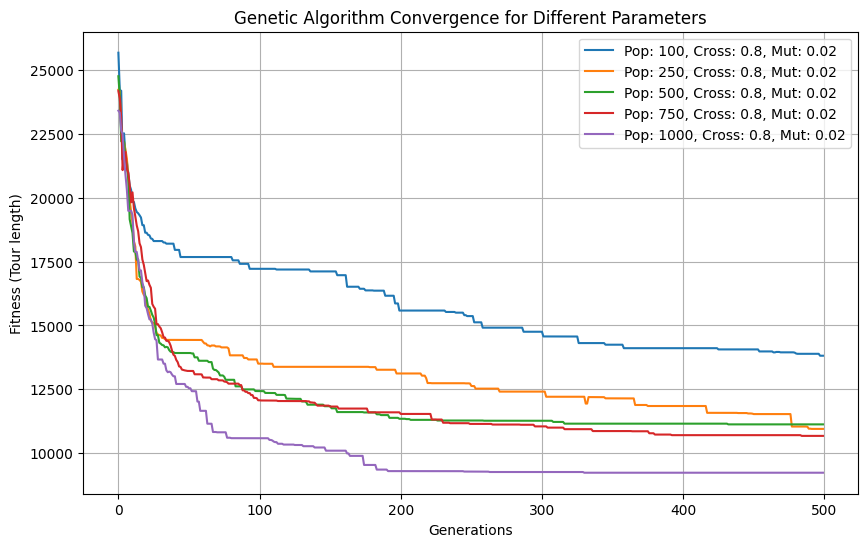

In [146]:
if __name__ == '__main__':
    filepath = "./TSP_files/berlin52.tsp"
    generations = 500
    tournament_size = 5

    # Get the parameters (you can choose to call any of the functions for different sets of parameters)
    pop_sizes, mutation_rates, crossover_rates = population_params()
    # pop_sizes, mutation_rates, crossover_rates = crossover_params()
    # pop_sizes, mutation_rates, crossover_rates = mutation_params()

    # Run the experiment
    run_experiment(filepath, generations, tournament_size, pop_sizes, mutation_rates, crossover_rates)

# Plotting results

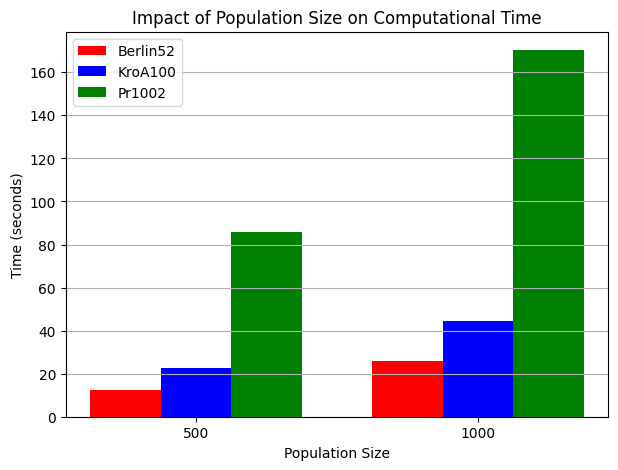

In [179]:
# Impact of Population Size on Computational Time
pop_sizes = ["500", "1000"]
berlin_pop_time = [12.5, 25.88]
kroA100_pop_time = [22.8, 44.45]
pr1002_pop_time = [85.6, 170.33]

x = np.arange(len(pop_sizes))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(x - width, berlin_pop_time, width, label="Berlin52", color="red")
ax.bar(x, kroA100_pop_time, width, label="KroA100", color="blue")
ax.bar(x + width, pr1002_pop_time, width, label="Pr1002", color="green")
ax.set_xlabel("Population Size")
ax.set_ylabel("Time (seconds)")
ax.set_title("Impact of Population Size on Computational Time")
ax.set_xticks(x)
ax.set_xticklabels(pop_sizes)
ax.legend()
ax.grid(axis="y")
plt.show()